In [1]:
from pycalphad.model import TestModel
import pycalphad
import pycalphad.variables as v
from pycalphad.core.halton import halton
import numpy as np
rng = np.random.RandomState(1769)

In [2]:
def sample_quasi(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled quasi-randomly from a Halton sequence.
    A Halton sequence is like a uniform random distribution, but the
    result will always be the same for a given 'comp_count' and 'pdof'.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = halton(sum(comp_count),
                 pdof * (sum(comp_count) - len(comp_count)), scramble=True)
    # Convert low-discrepancy sequence to normalized exponential
    # This will be uniformly distributed over the simplices
    pts = -np.log(pts)
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
        cur_idx = end_idx

    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def sample_pseudo(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled pseudo-randomly from a symmetric
    Dirichlet distribution.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = np.empty((pdof * (sum(comp_count) - len(comp_count)), sum(comp_count), ))
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] = rng.dirichlet(np.ones(ctx, dtype=np.int),
                                                size=(pdof * (sum(comp_count) - len(comp_count))))
        cur_idx = end_idx
    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def sample_baduniform(comp_count, pdof=10):
    """
    Sample 'pdof * (sum(comp_count) - len(comp_count))' points in
    composition space for the sublattice configuration specified
    by 'comp_count'. Points are sampled pseudo-randomly from a uniform
    distribution and then normalized to unity.
    Note: For systems with only one component, only one point will be
    returned, regardless of 'pdof'. This is because the degrees of freedom
    are zero for that case.

    Parameters
    ----------
    comp_count : list
        Number of components in each sublattice.
    pdof : int
        Number of points to sample per degree of freedom.

    Returns
    -------
    ndarray of generated points satisfying the mass balance.

    Examples
    --------
    >>> comps = [8,1] # 8 components in sublattice 1; only 1 in sublattice 2
    >>> pts = point_sample(comps, pdof=20) # 7 d.o.f, returns a 140x7 ndarray
    """
    # Generate Halton sequence with appropriate dimensions and size
    pts = np.empty((pdof * (sum(comp_count) - len(comp_count)), sum(comp_count), ))
    cur_idx = 0
    for ctx in comp_count:
        end_idx = cur_idx + ctx
        pts[:, cur_idx:end_idx] = rng.uniform(size=(pdof * (sum(comp_count) - len(comp_count)), ctx))
        pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]
        cur_idx = end_idx
    if len(pts) == 0:
        pts = np.atleast_2d([1] * len(comp_count))
    return pts
def test_opt(num_components, num_samples, sampler, solutions):
    result_array = np.empty((num_samples))
    comps = ['X{}'.format(str(i+1).zfill(len(str(num_components)))) for i in range(num_components)]
    print('{} COMPONENTS'.format(num_components))
    for idx in range(num_samples):
        print('TRIAL {}/{}'.format(idx+1, num_samples))
        solution = solutions[idx]
        tm = TestModel(None, comps, 'TEST', solution=solution, kmax=2)
        dbf = pycalphad.Database()
        dbf.add_phase('TEST', {}, [1])
        dbf.add_phase_constituents('TEST', [comps])
        conds = {v.P:101325, v.T:300}
        conds.update({v.X(i):sol for i, sol in list(zip(comps, solution))[:-1]})
        grid_opts = {'sampler': sampler, 'pdens': 100*num_components}
        eq = pycalphad.equilibrium(dbf, comps, 'TEST', conds, model=tm, verbose=False, grid_opts=grid_opts)
        if eq.GM < 1e-2:
            result_array[idx] = eq.attrs['solve_iterations']
        else:
            print(eq.GM)
            print(eq.X.values)
            print(solution)
            result_array[idx] = np.nan
    return result_array

In [3]:
%%time
comp_iters_pseudo = []
comp_iters_quasi = []
comp_iters_normunity = []
max_comps = 10
num_trials = 20
for num_comps in range(2, max_comps+1):
    solutions = [rng.dirichlet(np.ones(num_comps, dtype=np.int)) for i in range(num_trials)]
    from pycalphad.core.lower_convex_hull import lower_convex_hull, _initialize_array
    print('PSEUDO')
    results_pseudo = test_opt(num_comps, num_trials, sample_pseudo, solutions)
    print('QUASI')
    results_quasi = test_opt(num_comps, num_trials, sample_quasi, solutions)
    print('NORMUNITY')
    results_normunity = test_opt(num_comps, num_trials, sample_baduniform, solutions)
    comp_iters_pseudo.append(results_pseudo)
    comp_iters_quasi.append(results_quasi)
    comp_iters_normunity.append(results_normunity)
comp_iters_pseudo = np.array(comp_iters_pseudo, dtype=np.float)
comp_iters_quasi = np.array(comp_iters_quasi, dtype=np.float)
comp_iters_normunity = np.array(comp_iters_normunity, dtype=np.float)

PSEUDO
2 COMPONENTS
TRIAL 1/20
TRIAL 2/20
TRIAL 3/20
TRIAL 4/20
TRIAL 5/20
TRIAL 6/20
TRIAL 7/20
TRIAL 8/20
TRIAL 9/20
TRIAL 10/20
TRIAL 11/20
TRIAL 12/20
TRIAL 13/20
TRIAL 14/20
TRIAL 15/20
TRIAL 16/20
TRIAL 17/20
TRIAL 18/20
TRIAL 19/20
TRIAL 20/20
QUASI
2 COMPONENTS
TRIAL 1/20
TRIAL 2/20
TRIAL 3/20
TRIAL 4/20
TRIAL 5/20
TRIAL 6/20
TRIAL 7/20
TRIAL 8/20
TRIAL 9/20
TRIAL 10/20
TRIAL 11/20
TRIAL 12/20
TRIAL 13/20
TRIAL 14/20
TRIAL 15/20
TRIAL 16/20
TRIAL 17/20
TRIAL 18/20
TRIAL 19/20
TRIAL 20/20
NORMUNITY
2 COMPONENTS
TRIAL 1/20
TRIAL 2/20
TRIAL 3/20
TRIAL 4/20
TRIAL 5/20
TRIAL 6/20
TRIAL 7/20
TRIAL 8/20
TRIAL 9/20
TRIAL 10/20
TRIAL 11/20
TRIAL 12/20
TRIAL 13/20
TRIAL 14/20
TRIAL 15/20
TRIAL 16/20
TRIAL 17/20
TRIAL 18/20
TRIAL 19/20
TRIAL 20/20
PSEUDO
3 COMPONENTS
TRIAL 1/20
TRIAL 2/20
TRIAL 3/20
TRIAL 4/20
TRIAL 5/20
TRIAL 6/20
TRIAL 7/20
TRIAL 8/20
TRIAL 9/20
TRIAL 10/20
TRIAL 11/20
TRIAL 12/20
TRIAL 13/20
TRIAL 14/20
TRIAL 15/20
TRIAL 16/20
TRIAL 17/20
TRIAL 18/20
TRIAL 19/20
TRIAL 

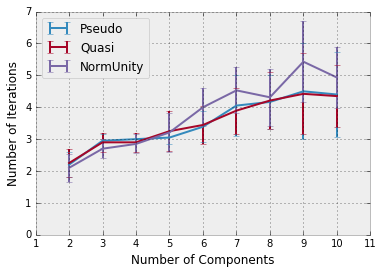

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
ax = plt.figure()
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_pseudo, axis=1),
             yerr=np.nanstd(comp_iters_pseudo, axis=1), label='Pseudo')
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_quasi, axis=1),
             yerr=np.nanstd(comp_iters_quasi, axis=1), label='Quasi')
plt.errorbar(np.arange(2, max_comps+1), np.nanmean(comp_iters_normunity, axis=1),
             yerr=np.nanstd(comp_iters_quasi, axis=1), label='NormUnity')
plt.ylim((0,None))
plt.xticks(list(range(1, max_comps+2)))
plt.xlabel('Number of Components')
plt.ylabel('Number of Iterations')
plt.legend(loc='best')
plt.show()

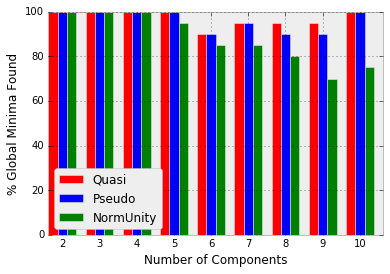

In [5]:
ind = np.arange(2, num_comps+1)  # the x locations for the groups
width = 0.5       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(2*ind, 100*np.invert(np.isnan(comp_iters_quasi)).sum(1)/comp_iters_quasi.shape[-1],
                width, color='r', label='Quasi')
rects2 = ax.bar(2*ind + width, 100*np.invert(np.isnan(comp_iters_pseudo)).sum(1)/comp_iters_pseudo.shape[-1],
                width, color='b', label='Pseudo')
rects3 = ax.bar(2*ind + 2*width, 100*np.invert(np.isnan(comp_iters_normunity)).sum(1)/comp_iters_normunity.shape[-1],
                width, color='g', label='NormUnity')
# add some text for labels, title and axes ticks
ax.set_xticks(2*ind + 1.5*width)
ax.set_xticklabels(tuple(ind))
ax.set_xlabel('Number of Components')
ax.set_ylabel('% Global Minima Found')
plt.legend(loc=3)
plt.show()